In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

#### Download Numerai Historical Targets 

In [8]:
### Download data at 2022-02-28 to get all the targets up to 2021 Dec 
download_data = True
signals_raw_targets = '../signals-data/signals_train_val_bbg_2021.parquet'
if download_data:
    #bbg = pd.read_csv('https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val_bbg.csv')
    bbg.to_parquet(signals_raw_targets )

In [9]:
bbg = pd.read_parquet(signals_raw_targets )
bbg['ticker'] = bbg['bloomberg_ticker'].str.split(' ',expand=True)[0]
bbg['country'] = bbg['bloomberg_ticker'].str.split(' ',expand=True)[1]
bbg['date'] = pd.to_datetime(bbg['friday_date'],format='%Y%m%d')

<AxesSubplot:xlabel='date'>

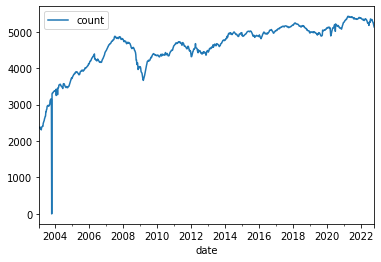

In [10]:
bbg.groupby('date')['target_4d'].agg(['count']).plot()

In [11]:
numerai_metadata = bbg[bbg['country']=='US'].groupby('bloomberg_ticker')['date'].agg(['max','min',])
numerai_metadata.columns = ['numerai_exit_date','numerai_entry_date',]
numerai_metadata.reset_index(inplace=True)
numerai_metadata['ticker'] = numerai_metadata['bloomberg_ticker'].str.split(' ',expand=True)[0]

In [12]:
numerai_metadata

,bloomberg_ticker,numerai_exit_date,numerai_entry_date,ticker
0,106760Q US,2008-10-24,2003-01-31,106760Q
1,1108Q US,2005-08-05,2003-01-31,1108Q
2,1323Q US,2004-06-18,2004-04-23,1323Q
3,1365732D US,2015-12-18,2010-07-02,1365732D
4,1482276D US,2017-01-13,2003-01-31,1482276D
...,...,...,...,...
6071,ZVO US,2015-04-24,2010-03-26,ZVO
6072,ZWS US,2022-10-07,2021-10-08,ZWS
6073,ZY US,2022-06-24,2022-01-14,ZY
6074,ZYXI US,2022-10-07,2019-07-12,ZYXI


#### Create Metadata (US stocks) 


Merge Metables of Numerai, Compustat, CRSP, SEC EDGAR, Option Metrics, Ravenpack to find tickers that have price, option and sentiment data 


1. Merge Numerai With CRSP using CRSP names (Map between bloomberg ticker and historical ticker)
2. Merge with Compustat using Compustat security (Map between cusip)
3. Merge with Compustat using Compustat history to get historical industry code (Map between gvkey)
4. Merge with Option Metrics using Option Metrics Names (Map between cusip)
5. Merge with RavenPack Company names  (Map between isin)



In [ ]:
### Compustat Company history point in time starts in 2007, 
refyear = 2021
crsp_link = pd.read_csv(f'../../data/CRSP_names_{refyear}.csv').dropna(subset=['permno'])
compustat_security_hist = pd.read_csv(f'../../data/Compustat_security_hist_{refyear}.csv').dropna(subset=['hisin'])
compustat_company_hist = pd.read_csv(f'../../data/Compustat_company_hist_{refyear}.csv').dropna(subset=['hgsubind'])
option_metrics_link = pd.read_csv(f'../../data/Option_Metrics_names_{refyear}.csv').dropna(subset=['secid'])
raven_pack_link = pd.read_csv(f'../../data/Ravenpack_wrds_rpa_company_names_{refyear}.csv').dropna(subset=['ticker'])

In [ ]:
compustat_security_hist['hschgenddt'] = compustat_security_hist['hschgenddt'].fillna('2099-12-31')

In [ ]:
## Merge CRSP with Numerai 
compustat_hist_merged = numerai_metadata.merge(crsp_link,left_on='ticker',right_on='ticker',how='left',)

In [ ]:
## Merge with Compustat Security history 
compustat_security_hist['hscusip8'] = [str(x)[:8] for x in compustat_security_hist['hscusip']]
compustat_hist_merged = compustat_hist_merged.merge(compustat_security_hist,left_on='ncusip',right_on='hscusip8',how='left',)

In [ ]:
### Keep only entries that exist after entering numerai universe
compustat_hist_merged['nameendt'] = pd.to_datetime(compustat_hist_merged['nameendt'])
compustat_hist_merged = compustat_hist_merged[compustat_hist_merged['nameendt']>=compustat_hist_merged['numerai_entry_date']]

In [ ]:
compustat_hist_merged.drop_duplicates(subset=['bloomberg_ticker','permno','gvkey','namedt','nameendt',],inplace=True)

In [ ]:
compustat_hist_merged.shape

In [ ]:
## Merge with Company history to get historical industry code
compustat_hist_merged = compustat_hist_merged.merge(compustat_company_hist,left_on='gvkey',right_on='gvkey',how='left',)

In [ ]:
compustat_hist_merged['hchgenddt'] = compustat_hist_merged['hchgenddt'].fillna('2099-12-31')

In [ ]:
compustat_hist_merged_valid = compustat_hist_merged.dropna(subset=['gvkey', 'hgind', 'hchgdt', 'hchgenddt',])

In [ ]:
## Create Change table when industry code or name is changed 
requried_cols = ['bloomberg_ticker', 'numerai_exit_date', 'numerai_entry_date', 
                 'gvkey', 'permno', 'hgsubind', 'hconm', 'hcik', 'hisin', 'ncusip',]
add_cols = ['hchgdt', 'hchgenddt', 'namedt', 'nameendt',]

In [ ]:
numerai_valid = compustat_hist_merged_valid.groupby(requried_cols)[add_cols].agg(['max','min',])
numerai_valid['map_start'] = numerai_valid['hchgdt']['min']
numerai_valid['map_end'] = numerai_valid['hchgenddt']['max']
numerai_valid['crsp_start'] = numerai_valid['namedt']['min']
numerai_valid['crsp_end'] = numerai_valid['nameendt']['max']

In [ ]:
compustat_hist_merged_filtered = numerai_valid[['map_start','map_end','crsp_start','crsp_end',]].reset_index()
compustat_hist_merged_filtered.columns = [x[0] for x in compustat_hist_merged_filtered.columns]

In [ ]:
## Merge with Option Metrics
compustat_hist_merged_filtered = compustat_hist_merged_filtered.merge(option_metrics_link,left_on='ncusip',right_on='cusip',how='left',).drop_duplicates(subset=requried_cols+['secid'])

In [ ]:
## Merge with Ravenpack 
output = compustat_hist_merged_filtered.merge(raven_pack_link[['rp_entity_id','isin']],left_on='hisin',right_on='isin',how='left',).drop_duplicates(subset=requried_cols+['rp_entity_id']).dropna(subset=['rp_entity_id'])

In [ ]:
## Save output 
requried_cols = requried_cols + ['secid','rp_entity_id'] + ['map_start','map_end', 'crsp_start', 'crsp_end',]
output[requried_cols].drop_duplicates().to_csv('data/numerai_signals_metadata_2021.csv',index=False)

#### Analyse Missing tickers 

In [ ]:
numerai_metadata_filtered = pd.read_csv('data/numerai_signals_metadata_2021.csv')

In [ ]:
numerai_metadata_filtered.shape

In [ ]:
numerai_metadata_filtered.drop_duplicates('bloomberg_ticker').shape

In [ ]:
tickers_not_mapped = set(numerai_metadata['bloomberg_ticker']) - set(numerai_metadata_filtered['bloomberg_ticker'])

In [ ]:
len(tickers_not_mapped)

In [ ]:
numerai_metadata[numerai_metadata['bloomberg_ticker'].isin(tickers_not_mapped)]

### Target Processing 

1. Filter targets to the required US stocks (based on metadata table we built)
2. Create id index (formed by friday_date and bloomberg_ticker), Create era column (friday_date in pd.datetime format)
3. Save parquet file (with id index), era, target_4d, target_20d as columns 

In [13]:
bbg = pd.read_parquet(signals_raw_targets)

In [15]:
numerai_metadata_filtered = pd.read_csv('../signals-data/numerai_signals_metadata_2021.csv')

In [16]:
filtered_targets = bbg[bbg['bloomberg_ticker'].isin(numerai_metadata_filtered['bloomberg_ticker'])]

In [17]:
filtered_targets['date'] = pd.to_datetime(filtered_targets['friday_date'],format='%Y%m%d')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
filtered_targets['era'] = filtered_targets['date']
filtered_targets.set_index(['friday_date','bloomberg_ticker'],inplace=True)
output_cols = ['era','target_4d','target_20d','raw_return_target_20d', 'factor_neutral_target_20d', 'factor_feat_neutral_target_20d', ]
filtered_targets[output_cols].to_parquet('../signals-data/numerai_signals_target_2021.parquet')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
pd.read_parquet('../signals-data/numerai_signals_target_2021.parquet').loc[20211231]

,era,target_4d,target_20d,raw_return_target_20d,factor_neutral_target_20d,factor_feat_neutral_target_20d
bloomberg_ticker,,,,,,
A US,2021-12-31,0.50,0.50,0.50,0.50,0.50
AA US,2021-12-31,1.00,0.75,0.75,0.75,0.75
AAL US,2021-12-31,0.50,0.25,0.50,0.50,0.25
AAN US,2021-12-31,0.25,0.25,0.25,0.50,0.25
AAON US,2021-12-31,0.50,0.25,0.25,0.25,0.25
...,...,...,...,...,...,...
ZS US,2021-12-31,1.00,0.75,0.50,0.75,0.75
ZTS US,2021-12-31,0.50,0.50,0.50,0.50,0.50
ZUMZ US,2021-12-31,0.25,0.50,0.50,0.50,0.50


### Generate Public Version of metadata 

Remove isin and cusip which are subject to database copyright. 

In [ ]:
numerai_metadata_filtered = pd.read_csv('data/numerai_signals_stock_metadata_2021.csv')

In [ ]:
public_cols = ['bloomberg_ticker','numerai_exit_date', 'numerai_entry_date', 'hconm', 'hcik', 'crsp_start', 'crsp_end',]

In [ ]:
numerai_metadata_filtered[public_cols].drop_duplicates().to_csv('data/numerai_signals_stock_metadata_public_2021.csv',index=False)

### Create Dataset for Public Release 


In [2]:
import numpy as np
import pandas as pd

In [8]:
## Read Train Data
target = pd.read_parquet("../signals-data/numerai_signals_target_2021.parquet").dropna()
target = target[
    (target["era"] <= "2021-12-31") & (target["era"] >= "2002-12-31")
]
train_data = target.copy()

features_metadata = dict()
features_metadata['feature_sets'] = dict()

for feature_set in ['stats', 'signature', 'catch22', 'ravenpack', 'financials', ]:
    feature_normalised = pd.read_parquet(f'../signals-data/numerai_signals_features_{feature_set}_normalised.parquet').astype(np.int8)
    feature_col = [col for col in feature_normalised.columns if not col.__contains__("sector_ranked")] 
    features_metadata['feature_sets'][feature_set] = feature_col
    train_data = train_data.merge(feature_normalised[feature_col],how='inner',left_index=True, right_index=True)


In [9]:
train_data.to_parquet("../signals-data/numerai_signals_features_all.parquet")

In [10]:
import json
with open("../signals-data/numerai_signals_features_all_metadata.json", "w") as f:
    json.dump(features_metadata,f)

In [11]:
train_data.columns

Index(['era', 'target_4d', 'target_20d', 'raw_return_target_20d',
       'factor_neutral_target_20d', 'factor_feat_neutral_target_20d',
       'feature_momentum_21_ranked', 'feature_momentum_63_ranked',
       'feature_momentum_252_ranked', 'feature_volatility_21_ranked',
       ...
       'feature_TrendFactor_ranked', 'feature_UpRecomm_ranked',
       'feature_VarCF_ranked', 'feature_VolMkt_ranked', 'feature_VolSD_ranked',
       'feature_VolumeTrend_ranked', 'feature_XFIN_ranked',
       'feature_zerotrade_ranked', 'feature_zerotradeAlt1_ranked',
       'feature_zerotradeAlt12_ranked'],
      dtype='object', length=588)

In [12]:
train_data.groupby('bloomberg_ticker').count()

,era,target_4d,target_20d,raw_return_target_20d,factor_neutral_target_20d,factor_feat_neutral_target_20d,feature_momentum_21_ranked,feature_momentum_63_ranked,feature_momentum_252_ranked,feature_volatility_21_ranked,...,feature_TrendFactor_ranked,feature_UpRecomm_ranked,feature_VarCF_ranked,feature_VolMkt_ranked,feature_VolSD_ranked,feature_VolumeTrend_ranked,feature_XFIN_ranked,feature_zerotrade_ranked,feature_zerotradeAlt1_ranked,feature_zerotradeAlt12_ranked
bloomberg_ticker,,,,,,,,,,,,,,,,,,,,,
A US,987,987,987,987,987,987,987,987,987,987,...,987,987,987,987,987,987,987,987,987,987
AA US,926,926,926,926,926,926,926,926,926,926,...,926,926,926,926,926,926,926,926,926,926
AAAP US,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
AAC US,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
AACC US,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZU US,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
ZUMZ US,811,811,811,811,811,811,811,811,811,811,...,811,811,811,811,811,811,811,811,811,811
ZUO US,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128


In [3]:
## Read Train Data
target = pd.read_parquet("../signals-data/numerai_signals_target_2021.parquet").dropna()
target = target[
    (target["era"] <= "2021-12-31") & (target["era"] >= "2002-12-31")
]
train_data = target.copy()

features_metadata = dict()
features_metadata['feature_sets'] = dict()

for feature_set in ['stats', 'signature', 'catch22', ]:
    feature_normalised = pd.read_parquet(f'../signals-data/numerai_signals_features_{feature_set}_normalised.parquet').astype(np.int8)
    feature_col = [col for col in feature_normalised.columns if not col.__contains__("sector_ranked")] 
    features_metadata['feature_sets'][feature_set] = feature_col
    train_data = train_data.merge(feature_normalised[feature_col],how='inner',left_index=True, right_index=True)


In [5]:
train_data.to_parquet("../signals-data/numerai_signals_features_price.parquet")

In [6]:
import json
with open("../signals-data/numerai_signals_features_price_metadata.json", "w") as f:
    json.dump(features_metadata,f)

In [1]:
import pandas as pd
import numpy as np
import json

In [4]:
for feature_set in ['stats', 'signature', 'catch22', 'ravenpack', 'financials', ]:
    
    features_metadata = dict()
    features_metadata['feature_sets'] = dict()
    
    ## Read Train Data
    target = pd.read_parquet("../signals-data/numerai_signals_target_2021.parquet").dropna()
    target = target[
        (target["era"] <= "2021-12-31") & (target["era"] >= "2002-12-31")
    ]
    train_data = target.copy()
    
    feature_normalised = pd.read_parquet(f'../signals-data/numerai_signals_features_{feature_set}_normalised.parquet').astype(np.int8)
    feature_col = [col for col in feature_normalised.columns if not col.__contains__("sector_ranked")] 
    features_metadata['feature_sets'][feature_set] = feature_col
    train_data = train_data.merge(feature_normalised[feature_col],how='inner',left_index=True, right_index=True)
    train_data.to_parquet(f"../signals-data/numerai_signals_features_{feature_set}.parquet")
    
    import json
    with open(f"../signals-data/numerai_signals_features_{feature_set}_metadata.json", "w") as f:
        json.dump(features_metadata,f)

In [20]:
import numpy as np

In [27]:
for feature_set in ['baseline', ]:
    
    features_metadata = dict()
    features_metadata['feature_sets'] = dict()
    
    ## Read Train Data
    target = pd.read_parquet("../signals-data/numerai_signals_target_2021.parquet").dropna()
    target = target[
        (target["era"] <= "2021-12-31") & (target["era"] >= "2002-12-31")
    ]
    train_data = target.copy()
    
    feature_normalised = pd.read_parquet(f'../signals-data/numerai_signals_features_{feature_set}.parquet')

    #arrays = [feature_normalised.index.get_level_values('friday_date').values, feature_normalised.index.get_level_values('bloomberg_ticker').values]
    #feature_normalised.index = pd.MultiIndex.from_arrays(arrays, names=('friday_date', 'bloomberg_ticker'))
    #feature_normalised.reindex(target.index).dropna().to_parquet(f"../signals-data/numerai_signals_features_{feature_set}.parquet")
    
    import json
    with open(f"../signals-data/numerai_signals_features_{feature_set}_metadata.json", "w") as f:
        json.dump(features_metadata,f)

In [6]:
import pandas as pd
df = pd.read_parquet("../signals-data/numerai_signals_features_all.parquet").dropna()

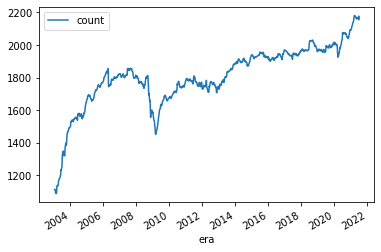

In [16]:
fig = df.groupby('era')['target_20d'].agg(['count']).iloc[:-26].plot()

In [18]:
fig.figure.savefig('Numerai-Signals-universe.jpg')